In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from os.path import expanduser

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME, DATASET_JSON_PATH

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

/home/ando/.conda/envs/rv_timm0412/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
import os, torch
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32" #to prevent cuda out of memory error
torch.cuda.empty_cache()


#For reproducibility
torch.manual_seed(13)



### Configuration

In [3]:
from experiment_configs.configs import *
config = satmae_large_config


### Create Rastervision datasets

In [4]:
from torch.utils.data import ConcatDataset
import json
from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, warn_if_nan_in_raw_raster
from utils.data_management import observation_factory, characterize_dataset
import random

#set the seed
random.seed(13)

# get the current working directory
root_dir = os.getcwd()

# define the relative path to the dataset JSON file
json_rel_path = '../' + DATASET_JSON_PATH

# combine the root directory with the relative path
json_abs_path = os.path.join(root_dir, json_rel_path)

dataset_json = json.load(open(json_abs_path, 'r'))
all_observations = observation_factory(dataset_json)

#find the highest cluster id
max_cluster_id = max([observation['cluster_id'] for observation in dataset_json])


# Randomly split the data into training and validation
val_split = random.randint(0, max_cluster_id+1)

training_scenes = []
validation_scenes = []

for observation in all_observations:
    if observation.cluster_id == val_split: 
        validation_scenes.append(observation_to_scene(config, observation))
    else:
        training_scenes.append(observation_to_scene(config, observation))


training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes #random window sampling happens here
]
validation_datasets = [
    scene_to_validation_ds(config, scene) for scene in validation_scenes
    scene_to_inference_ds(config, scene, full_image=False, stride=int(config.tile_size/2)) for scene in validation_scenes # better performance with this
]

train_dataset_merged = ConcatDataset(training_datasets)
val_dataset_merged = ConcatDataset(validation_datasets)

print('Validation split cluster_id:', val_split)
print ('Training dataset size: {:4d} images | Number of observations: {:}'.format(len(train_dataset_merged), len(training_scenes)))
print ('Testing dataset size: {:4d}  images | Number of observations: {:}'.format(len(val_dataset_merged), len(validation_scenes)))

mine_percentage_aoi = characterize_dataset(training_scenes, validation_scenes)

2023-12-23 12:44:48:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s2/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s2.tif.
2023-12-23 12:44:48:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/annotations/Kathajodi_Cuttack_85-85_20-44_2022-05-01_annotations.geojson.
2023-12-23 12:44:48:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/rivers/Kathajodi_Cuttack_85-85_20-44_rivers_1000m.geojson.
2023-12-23 12:44:48:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in https://storage.googleapis.com/sand_mining_medi

Validation split cluster_id: 4
Training dataset size: 2008 images | Number of observations: 72
Testing dataset size:  266  images | Number of observations: 8
Total dataset has 2.93%  mining area.
Training dataset has 3.05%  mining area.
Validation dataset has 2.15%  mining area.
Within AOIs, total dataset has 6.72%  mining area.
Outside AOIs, total dataset has 0.06%  mining area.

The median percentage of mine in an observation is 3.26%
The median number of mine pixels in an observation is 38059

The median number pixels in an observation is 1301008


## Update the loss weights to account for the imbalanced dataset

In [5]:
# config.mine_class_loss_weight = (100 - mine_percentage_aoi) / mine_percentage_aoi
# config.mine_class_loss_weight = 1
config.mine_class_loss_weight

6.0

## Visualize the datasets




 Val Dataset


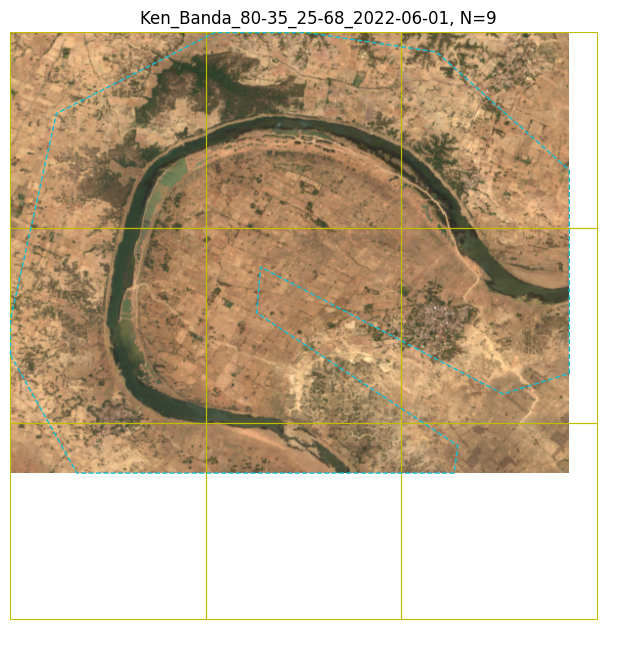

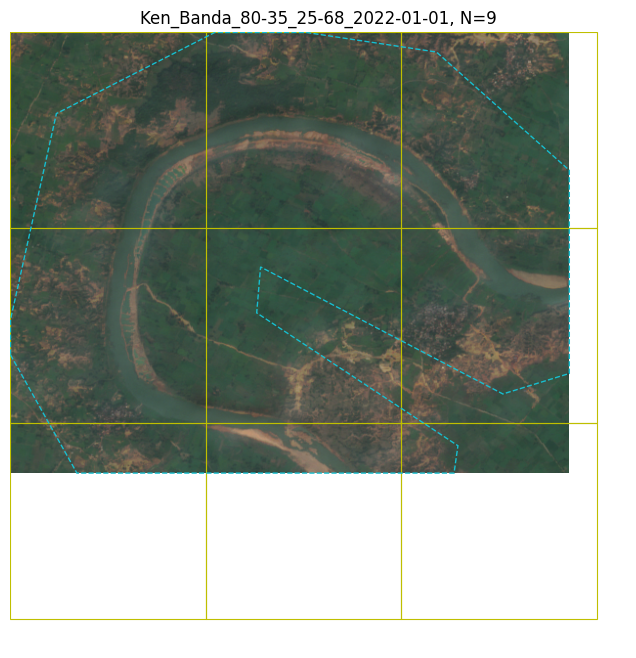

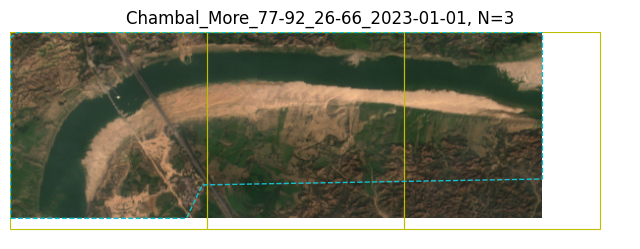

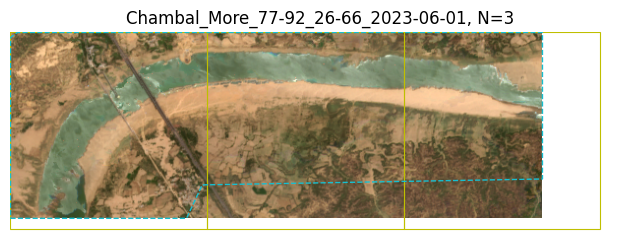

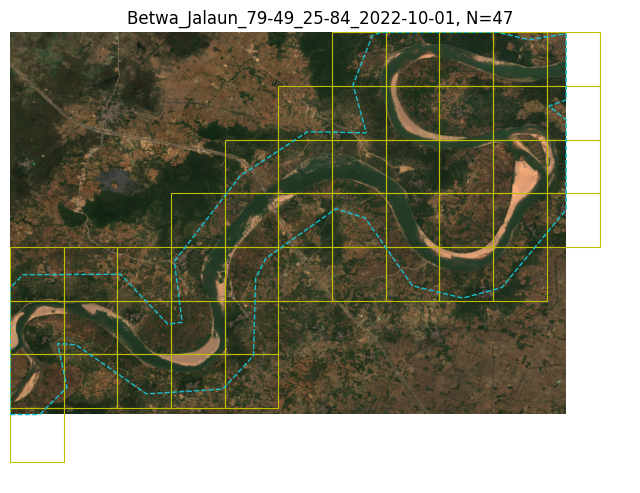

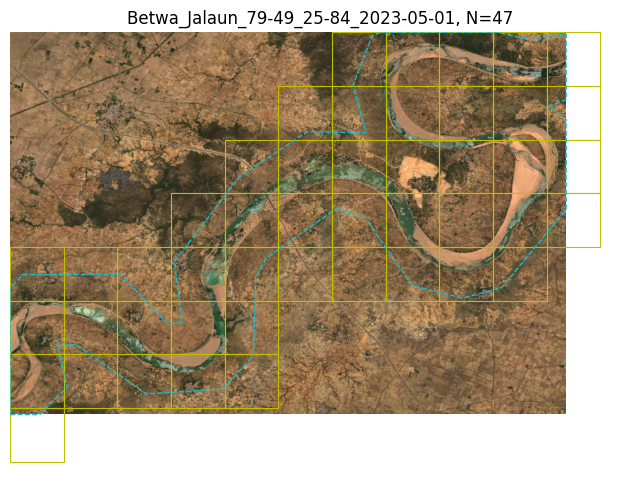

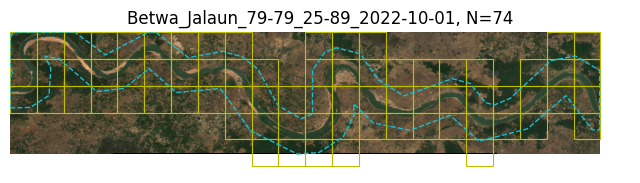

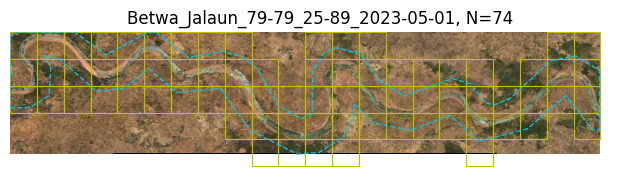

In [6]:
from utils.visualizing import visualize_dataset

# print ('Training Dataset')
# for ds in training_datasets:
#     visualize_dataset(ds)

print("\n\n\n Val Dataset")

for ds in validation_datasets:
    visualize_dataset(ds)

# Train

In [7]:
from models.model_factory import model_factory, print_trainable_parameters
from ml.optimizer_factory import optimizer_factory
from ml.learner import BinarySegmentationLearner

_, _, n_channels = training_datasets[0].scene.raster_source.shape
model = model_factory(
    config,
    n_channels=n_channels,
)

optimizer = optimizer_factory(config, model)

learner = BinarySegmentationLearner(
    config=config,
    model=model,
    optimizer=optimizer,
    train_ds=train_dataset_merged,  # for development and debugging, use training_datasets[0] or similar to speed up
    valid_ds=val_dataset_merged,  # for development and debugging, use training_datasets[1] or similar to speed up
    output_dir=expanduser("~/sandmining-watch/out/OUTPUT_DIR"),
)
print_trainable_parameters(learner.model)

SatMae: Loading encoder weights from /data/sand_mining/checkpoints/satmae_orig/pretrain-vit-large-e199.pth
Position interpolate from 12x12 to 25x25
Warning! Missing keys:
['channel_cls_embed', 'head.weight', 'head.bias']
SatMaePretrained: Freezing encoder weights
Number of parameters loaded: 298


2023-12-23 12:45:20:rastervision: INFO - train_ds: 2008 items
2023-12-23 12:45:20:rastervision: INFO - valid_ds: 266 items


trainable params: 7669505 || all params: 311124227 || trainable%: 2.47


#### Check GPU Activity

You can continuously monitor your GPU activity by using the command in the terminal


`watch -d -n 0.5 nvidia-smi`

In [6]:
# Run this cell if you want to log the run to W&B. You might need to authenticate to W&B.
learner.initialize_wandb_run()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andoshah (sandmining-watch). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [7]:
learner.train(epochs=20)

2023-12-23 08:15:43:rastervision: INFO - epoch: 0


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 08:24:50:rastervision: INFO - metrics:
{'avg_f1': 0.9463236927986145,
 'avg_precision': 0.9701762199401855,
 'avg_recall': 0.9236158728599548,
 'epoch': 0,
 'other_f1': 0.9593407511711121,
 'other_precision': 0.9922460317611694,
 'other_recall': 0.9285477995872498,
 'sandmine_average_precision': 0.4294133341488082,
 'sandmine_best_f1_score': 0.46441704608573314,
 'sandmine_best_threshold': 0.61501414,
 'sandmine_f1': 0.3706069886684418,
 'sandmine_precision': 0.24489270150661469,
 'sandmine_recall': 0.7615386247634888,
 'train_bce_loss': 0.012621328650242779,
 'train_dice_loss': 0.01788951676205335,
 'train_time': datetime.timedelta(seconds=491, microseconds=989980),
 'val_bce_loss': 0.007243558428341285,
 'val_dice_loss': 0.020610741206577847,
 'valid_time': datetime.timedelta(seconds=55, microseconds=631582)}


Best Threshold=0.615014, Best F1 Score=0.464


2023-12-23 08:24:52:rastervision: INFO - epoch: 1


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 08:33:54:rastervision: INFO - metrics:
{'avg_f1': 0.9182499647140503,
 'avg_precision': 0.967192530632019,
 'avg_recall': 0.8740219473838806,
 'epoch': 1,
 'other_f1': 0.9311243295669556,
 'other_precision': 0.9917863011360168,
 'other_recall': 0.8774553537368774,
 'sandmine_average_precision': 0.422016583793856,
 'sandmine_best_f1_score': 0.4360288208587187,
 'sandmine_best_threshold': 0.7872453,
 'sandmine_f1': 0.26300525665283203,
 'sandmine_precision': 0.15896542370319366,
 'sandmine_recall': 0.7611885070800781,
 'train_bce_loss': 0.010407335729712985,
 'train_dice_loss': 0.017019271850585938,
 'train_time': datetime.timedelta(seconds=486, microseconds=572139),
 'val_bce_loss': 0.00832062556331319,
 'val_dice_loss': 0.020097628571933375,
 'valid_time': datetime.timedelta(seconds=55, microseconds=548738)}


Best Threshold=0.787245, Best F1 Score=0.436


2023-12-23 08:33:56:rastervision: INFO - epoch: 2


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 08:43:00:rastervision: INFO - metrics:
{'avg_f1': 0.948137640953064,
 'avg_precision': 0.9683047533035278,
 'avg_recall': 0.9287934899330139,
 'epoch': 2,
 'other_f1': 0.9622783660888672,
 'other_precision': 0.9902142286300659,
 'other_recall': 0.9358755350112915,
 'sandmine_average_precision': 0.4698047181384327,
 'sandmine_best_f1_score': 0.45069592571617095,
 'sandmine_best_threshold': 0.7767543,
 'sandmine_f1': 0.366019070148468,
 'sandmine_precision': 0.24829111993312836,
 'sandmine_recall': 0.696056067943573,
 'train_bce_loss': 0.009004426667414814,
 'train_dice_loss': 0.01664860600019356,
 'train_time': datetime.timedelta(seconds=488, microseconds=130307),
 'val_bce_loss': 0.005754416150258,
 'val_dice_loss': 0.02003381843853714,
 'valid_time': datetime.timedelta(seconds=55, microseconds=670602)}


Best Threshold=0.776754, Best F1 Score=0.451


2023-12-23 08:43:01:rastervision: INFO - epoch: 3


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 08:52:04:rastervision: INFO - metrics:
{'avg_f1': 0.9222140312194824,
 'avg_precision': 0.9686822891235352,
 'avg_recall': 0.8799998760223389,
 'epoch': 3,
 'other_f1': 0.934536337852478,
 'other_precision': 0.9929625391960144,
 'other_recall': 0.8826037049293518,
 'sandmine_average_precision': 0.4410958188949597,
 'sandmine_best_f1_score': 0.44637193681839177,
 'sandmine_best_threshold': 0.8796015,
 'sandmine_f1': 0.281093031167984,
 'sandmine_precision': 0.17075572907924652,
 'sandmine_recall': 0.7944310307502747,
 'train_bce_loss': 0.008544205669387878,
 'train_dice_loss': 0.01660229580335883,
 'train_time': datetime.timedelta(seconds=487, microseconds=420848),
 'val_bce_loss': 0.007002532930302441,
 'val_dice_loss': 0.02014848164149693,
 'valid_time': datetime.timedelta(seconds=55, microseconds=471757)}


Best Threshold=0.879601, Best F1 Score=0.446


2023-12-23 08:52:06:rastervision: INFO - epoch: 4


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 09:01:08:rastervision: INFO - metrics:
{'avg_f1': 0.9441004991531372,
 'avg_precision': 0.968424916267395,
 'avg_recall': 0.9209679961204529,
 'epoch': 4,
 'other_f1': 0.957927942276001,
 'other_precision': 0.9908671379089355,
 'other_recall': 0.9271082878112793,
 'sandmine_average_precision': 0.45953317053324044,
 'sandmine_best_f1_score': 0.4515720601838101,
 'sandmine_best_threshold': 0.80433273,
 'sandmine_f1': 0.34957122802734375,
 'sandmine_precision': 0.2309032529592514,
 'sandmine_recall': 0.7191778421401978,
 'train_bce_loss': 0.008188987633146613,
 'train_dice_loss': 0.016573913543822757,
 'train_time': datetime.timedelta(seconds=486, microseconds=530470),
 'val_bce_loss': 0.0056479909366234805,
 'val_dice_loss': 0.019976243040615453,
 'valid_time': datetime.timedelta(seconds=55, microseconds=544858)}


Best Threshold=0.804333, Best F1 Score=0.452


2023-12-23 09:01:10:rastervision: INFO - epoch: 5


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 09:10:15:rastervision: INFO - metrics:
{'avg_f1': 0.9543505311012268,
 'avg_precision': 0.9703418612480164,
 'avg_recall': 0.9388777613639832,
 'epoch': 5,
 'other_f1': 0.9677666425704956,
 'other_precision': 0.9911293387413025,
 'other_recall': 0.9454799294471741,
 'sandmine_average_precision': 0.5075679111032341,
 'sandmine_best_f1_score': 0.4921293379369439,
 'sandmine_best_threshold': 0.7937555,
 'sandmine_f1': 0.4109214246273041,
 'sandmine_precision': 0.28720003366470337,
 'sandmine_recall': 0.7219085693359375,
 'train_bce_loss': 0.00775691047607665,
 'train_dice_loss': 0.016420294089146345,
 'train_time': datetime.timedelta(seconds=489, microseconds=674362),
 'val_bce_loss': 0.005247040350634353,
 'val_dice_loss': 0.01962867177518687,
 'valid_time': datetime.timedelta(seconds=55, microseconds=446618)}


Best Threshold=0.793755, Best F1 Score=0.492


2023-12-23 09:10:17:rastervision: INFO - epoch: 6


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 09:19:20:rastervision: INFO - metrics:
{'avg_f1': 0.9525145888328552,
 'avg_precision': 0.9727190732955933,
 'avg_recall': 0.9331323504447937,
 'epoch': 6,
 'other_f1': 0.9645348191261292,
 'other_precision': 0.9937847852706909,
 'other_recall': 0.9369574189186096,
 'sandmine_average_precision': 0.5333087541796803,
 'sandmine_best_f1_score': 0.5187774423056775,
 'sandmine_best_threshold': 0.8359512,
 'sandmine_f1': 0.41628554463386536,
 'sandmine_precision': 0.2804344892501831,
 'sandmine_recall': 0.8074288964271545,
 'train_bce_loss': 0.00712028585107203,
 'train_dice_loss': 0.01643433893819254,
 'train_time': datetime.timedelta(seconds=487, microseconds=517177),
 'val_bce_loss': 0.0049647272081303415,
 'val_dice_loss': 0.01978079358437904,
 'valid_time': datetime.timedelta(seconds=55, microseconds=638539)}


Best Threshold=0.835951, Best F1 Score=0.519


2023-12-23 09:19:22:rastervision: INFO - epoch: 7


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 09:28:27:rastervision: INFO - metrics:
{'avg_f1': 0.9486674666404724,
 'avg_precision': 0.9721187949180603,
 'avg_recall': 0.9263210296630859,
 'epoch': 7,
 'other_f1': 0.960778534412384,
 'other_precision': 0.9937913417816162,
 'other_recall': 0.9298884868621826,
 'sandmine_average_precision': 0.5489156664882032,
 'sandmine_best_f1_score': 0.5184243008612938,
 'sandmine_best_threshold': 0.85704124,
 'sandmine_f1': 0.3934115469455719,
 'sandmine_precision': 0.2598908543586731,
 'sandmine_recall': 0.809083878993988,
 'train_bce_loss': 0.007106219629842447,
 'train_dice_loss': 0.016224747160041474,
 'train_time': datetime.timedelta(seconds=489, microseconds=868165),
 'val_bce_loss': 0.005600840973674803,
 'val_dice_loss': 0.019275310344265818,
 'valid_time': datetime.timedelta(seconds=55, microseconds=770164)}


Best Threshold=0.857041, Best F1 Score=0.518


2023-12-23 09:28:29:rastervision: INFO - epoch: 8


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 09:37:34:rastervision: INFO - metrics:
{'avg_f1': 0.9634629487991333,
 'avg_precision': 0.9718517661094666,
 'avg_recall': 0.955217719078064,
 'epoch': 8,
 'other_f1': 0.9766073822975159,
 'other_precision': 0.9903469085693359,
 'other_recall': 0.9632439017295837,
 'sandmine_average_precision': 0.5470897196948618,
 'sandmine_best_f1_score': 0.5290691497068455,
 'sandmine_best_threshold': 0.7079779,
 'sandmine_f1': 0.4769660234451294,
 'sandmine_precision': 0.36404186487197876,
 'sandmine_recall': 0.691450834274292,
 'train_bce_loss': 0.007367633253454687,
 'train_dice_loss': 0.016340884554433634,
 'train_time': datetime.timedelta(seconds=488, microseconds=829511),
 'val_bce_loss': 0.004697941747823156,
 'val_dice_loss': 0.019580928902877003,
 'valid_time': datetime.timedelta(seconds=55, microseconds=681495)}


Best Threshold=0.707978, Best F1 Score=0.529


2023-12-23 09:37:35:rastervision: INFO - epoch: 9


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 09:46:38:rastervision: INFO - metrics:
{'avg_f1': 0.956279993057251,
 'avg_precision': 0.9744225144386292,
 'avg_recall': 0.938800573348999,
 'epoch': 9,
 'other_f1': 0.9676073789596558,
 'other_precision': 0.9947952032089233,
 'other_recall': 0.9418661594390869,
 'sandmine_average_precision': 0.5787792515595046,
 'sandmine_best_f1_score': 0.5447001856161722,
 'sandmine_best_threshold': 0.8446873,
 'sandmine_f1': 0.4471398591995239,
 'sandmine_precision': 0.3049120008945465,
 'sandmine_recall': 0.8380553126335144,
 'train_bce_loss': 0.007339615270910985,
 'train_dice_loss': 0.01625861209702207,
 'train_time': datetime.timedelta(seconds=486, microseconds=314037),
 'val_bce_loss': 0.00498940084213601,
 'val_dice_loss': 0.01935781034311854,
 'valid_time': datetime.timedelta(seconds=55, microseconds=937763)}


Best Threshold=0.844687, Best F1 Score=0.545


2023-12-23 09:46:39:rastervision: INFO - epoch: 10


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 09:55:42:rastervision: INFO - metrics:
{'avg_f1': 0.960003137588501,
 'avg_precision': 0.9727293252944946,
 'avg_recall': 0.947605550289154,
 'epoch': 10,
 'other_f1': 0.9724669456481934,
 'other_precision': 0.992267370223999,
 'other_recall': 0.9534412622451782,
 'sandmine_average_precision': 0.5785715034983897,
 'sandmine_best_f1_score': 0.5463554159206333,
 'sandmine_best_threshold': 0.7901065,
 'sandmine_f1': 0.46004295349121094,
 'sandmine_precision': 0.3306480646133423,
 'sandmine_recall': 0.7558258175849915,
 'train_bce_loss': 0.006787601695117723,
 'train_dice_loss': 0.016200308780746155,
 'train_time': datetime.timedelta(seconds=486, microseconds=703679),
 'val_bce_loss': 0.00498465218938383,
 'val_dice_loss': 0.019232597566188725,
 'valid_time': datetime.timedelta(seconds=55, microseconds=611496)}


Best Threshold=0.790106, Best F1 Score=0.546


2023-12-23 09:55:43:rastervision: INFO - epoch: 11


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 10:04:46:rastervision: INFO - metrics:
{'avg_f1': 0.9374201893806458,
 'avg_precision': 0.9724333882331848,
 'avg_recall': 0.9048407673835754,
 'epoch': 11,
 'other_f1': 0.9486720561981201,
 'other_precision': 0.9953783750534058,
 'other_recall': 0.9061524868011475,
 'sandmine_average_precision': 0.5788095479718759,
 'sandmine_best_f1_score': 0.54604146470058,
 'sandmine_best_threshold': 0.8903671,
 'sandmine_f1': 0.34846699237823486,
 'sandmine_precision': 0.21838955581188202,
 'sandmine_recall': 0.8617340326309204,
 'train_bce_loss': 0.006847849880081724,
 'train_dice_loss': 0.016174627965190022,
 'train_time': datetime.timedelta(seconds=487, microseconds=422676),
 'val_bce_loss': 0.005791570459093366,
 'val_dice_loss': 0.01984304413759619,
 'valid_time': datetime.timedelta(seconds=55, microseconds=596787)}


Best Threshold=0.890367, Best F1 Score=0.546


2023-12-23 10:04:48:rastervision: INFO - epoch: 12


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 10:13:53:rastervision: INFO - metrics:
{'avg_f1': 0.9533776044845581,
 'avg_precision': 0.9724345207214355,
 'avg_recall': 0.9350532293319702,
 'epoch': 12,
 'other_f1': 0.9656035304069519,
 'other_precision': 0.9933586716651917,
 'other_recall': 0.9393572211265564,
 'sandmine_average_precision': 0.5951856309420603,
 'sandmine_best_f1_score': 0.5540068345931444,
 'sandmine_best_threshold': 0.8297714,
 'sandmine_f1': 0.4191761612892151,
 'sandmine_precision': 0.28480300307273865,
 'sandmine_recall': 0.7936099171638489,
 'train_bce_loss': 0.006918167213044794,
 'train_dice_loss': 0.016154323441098885,
 'train_time': datetime.timedelta(seconds=488, microseconds=464551),
 'val_bce_loss': 0.005484310307897123,
 'val_dice_loss': 0.01956645707438763,
 'valid_time': datetime.timedelta(seconds=56, microseconds=221868)}


Best Threshold=0.829771, Best F1 Score=0.554


2023-12-23 10:13:55:rastervision: INFO - epoch: 13


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 10:23:00:rastervision: INFO - metrics:
{'avg_f1': 0.9451131820678711,
 'avg_precision': 0.9740241765975952,
 'avg_recall': 0.917868971824646,
 'epoch': 13,
 'other_f1': 0.9559808373451233,
 'other_precision': 0.9960944056510925,
 'other_recall': 0.9189730286598206,
 'sandmine_average_precision': 0.5695189419196218,
 'sandmine_best_f1_score': 0.5388769368657942,
 'sandmine_best_threshold': 0.8977979,
 'sandmine_f1': 0.3879894018173218,
 'sandmine_precision': 0.24872763454914093,
 'sandmine_recall': 0.8815872669219971,
 'train_bce_loss': 0.006748388962916644,
 'train_dice_loss': 0.015910177116849982,
 'train_time': datetime.timedelta(seconds=489, microseconds=552285),
 'val_bce_loss': 0.005337533197904888,
 'val_dice_loss': 0.019409122323631345,
 'valid_time': datetime.timedelta(seconds=56, microseconds=176497)}


Best Threshold=0.897798, Best F1 Score=0.539


2023-12-23 10:23:02:rastervision: INFO - epoch: 14


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 10:32:07:rastervision: INFO - metrics:
{'avg_f1': 0.9551289677619934,
 'avg_precision': 0.97138512134552,
 'avg_recall': 0.9394079446792603,
 'epoch': 14,
 'other_f1': 0.9680275917053223,
 'other_precision': 0.9920024275779724,
 'other_recall': 0.9451842904090881,
 'sandmine_average_precision': 0.552848968980988,
 'sandmine_best_f1_score': 0.5221368807601242,
 'sandmine_best_threshold': 0.8092958,
 'sandmine_f1': 0.42217928171157837,
 'sandmine_precision': 0.29383760690689087,
 'sandmine_recall': 0.7495782971382141,
 'train_bce_loss': 0.006762841783196803,
 'train_dice_loss': 0.016150953285247682,
 'train_time': datetime.timedelta(seconds=489, microseconds=778844),
 'val_bce_loss': 0.005100227836379432,
 'val_dice_loss': 0.019619907651628767,
 'valid_time': datetime.timedelta(seconds=55, microseconds=326784)}


Best Threshold=0.809296, Best F1 Score=0.522


2023-12-23 10:32:09:rastervision: INFO - epoch: 15


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 10:41:14:rastervision: INFO - metrics:
{'avg_f1': 0.92238849401474,
 'avg_precision': 0.9714973568916321,
 'avg_recall': 0.8780056238174438,
 'epoch': 15,
 'other_f1': 0.9332070350646973,
 'other_precision': 0.995613157749176,
 'other_recall': 0.8781628012657166,
 'sandmine_average_precision': 0.556082804735397,
 'sandmine_best_f1_score': 0.5311538434943749,
 'sandmine_best_threshold': 0.9271069,
 'sandmine_f1': 0.2970467805862427,
 'sandmine_precision': 0.17897851765155792,
 'sandmine_recall': 0.8728413581848145,
 'train_bce_loss': 0.0065684209306876495,
 'train_dice_loss': 0.01617316135847236,
 'train_time': datetime.timedelta(seconds=489, microseconds=397311),
 'val_bce_loss': 0.007064268105012134,
 'val_dice_loss': 0.01978785292546552,
 'valid_time': datetime.timedelta(seconds=55, microseconds=830318)}


Best Threshold=0.927107, Best F1 Score=0.531


2023-12-23 10:41:16:rastervision: INFO - epoch: 16


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 10:50:20:rastervision: INFO - metrics:
{'avg_f1': 0.9577488303184509,
 'avg_precision': 0.9752344489097595,
 'avg_recall': 0.9408792853355408,
 'epoch': 16,
 'other_f1': 0.9687262773513794,
 'other_precision': 0.9953200817108154,
 'other_recall': 0.9435166716575623,
 'sandmine_average_precision': 0.5902006163671213,
 'sandmine_best_f1_score': 0.5512050303009073,
 'sandmine_best_threshold': 0.82689947,
 'sandmine_f1': 0.4604361951351166,
 'sandmine_precision': 0.31515607237815857,
 'sandmine_recall': 0.8542070984840393,
 'train_bce_loss': 0.006746594174449662,
 'train_dice_loss': 0.015838474866403527,
 'train_time': datetime.timedelta(seconds=488, microseconds=887546),
 'val_bce_loss': 0.004616014043191322,
 'val_dice_loss': 0.019440568479380214,
 'valid_time': datetime.timedelta(seconds=55, microseconds=620164)}


Best Threshold=0.826899, Best F1 Score=0.551


2023-12-23 10:50:22:rastervision: INFO - epoch: 17


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 10:59:31:rastervision: INFO - metrics:
{'avg_f1': 0.9655559062957764,
 'avg_precision': 0.973320722579956,
 'avg_recall': 0.9579139947891235,
 'epoch': 17,
 'other_f1': 0.9780285954475403,
 'other_precision': 0.991197943687439,
 'other_recall': 0.9652045965194702,
 'sandmine_average_precision': 0.5845085565469518,
 'sandmine_best_f1_score': 0.5487920379846148,
 'sandmine_best_threshold': 0.6637385,
 'sandmine_f1': 0.5020056962966919,
 'sandmine_precision': 0.38581961393356323,
 'sandmine_recall': 0.7183217406272888,
 'train_bce_loss': 0.0069294104063178435,
 'train_dice_loss': 0.016099718937360907,
 'train_time': datetime.timedelta(seconds=493, microseconds=83690),
 'val_bce_loss': 0.004756231505171697,
 'val_dice_loss': 0.019598164952787243,
 'valid_time': datetime.timedelta(seconds=55, microseconds=484668)}


Best Threshold=0.663738, Best F1 Score=0.549


2023-12-23 10:59:33:rastervision: INFO - epoch: 18


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 11:08:34:rastervision: INFO - metrics:
{'avg_f1': 0.9522003531455994,
 'avg_precision': 0.9726800918579102,
 'avg_recall': 0.9325652122497559,
 'epoch': 18,
 'other_f1': 0.9642226696014404,
 'other_precision': 0.9937986135482788,
 'other_recall': 0.9363561868667603,
 'sandmine_average_precision': 0.5837665874017368,
 'sandmine_best_f1_score': 0.5569550427507585,
 'sandmine_best_threshold': 0.8485244,
 'sandmine_f1': 0.41440126299858093,
 'sandmine_precision': 0.27866101264953613,
 'sandmine_recall': 0.8079826831817627,
 'train_bce_loss': 0.006747138452719882,
 'train_dice_loss': 0.016004205224998444,
 'train_time': datetime.timedelta(seconds=486, microseconds=276791),
 'val_bce_loss': 0.004887349175331288,
 'val_dice_loss': 0.01967720877855344,
 'valid_time': datetime.timedelta(seconds=55, microseconds=485166)}


Best Threshold=0.848524, Best F1 Score=0.557


2023-12-23 11:08:36:rastervision: INFO - epoch: 19


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

2023-12-23 11:17:40:rastervision: INFO - metrics:
{'avg_f1': 0.9478306174278259,
 'avg_precision': 0.9732315540313721,
 'avg_recall': 0.9237217903137207,
 'epoch': 19,
 'other_f1': 0.9592905640602112,
 'other_precision': 0.9949832558631897,
 'other_recall': 0.926069974899292,
 'sandmine_average_precision': 0.5831648039345458,
 'sandmine_best_f1_score': 0.5511783200882064,
 'sandmine_best_threshold': 0.8794869,
 'sandmine_f1': 0.3959439694881439,
 'sandmine_precision': 0.25840070843696594,
 'sandmine_recall': 0.8465529084205627,
 'train_bce_loss': 0.006229720742579,
 'train_dice_loss': 0.0159523515587309,
 'train_time': datetime.timedelta(seconds=488, microseconds=49976),
 'val_bce_loss': 0.005465924291682423,
 'val_dice_loss': 0.019237088081531954,
 'valid_time': datetime.timedelta(seconds=55, microseconds=797339)}


Best Threshold=0.879487, Best F1 Score=0.551


## Evaluate 

Initialize evaluation_datasets and predictor.
evaluation_datasets and validation_datasets are based on identical scenes, but have different sliding window configurations.

In [9]:
config = satmae_large_inf_config
config.tile_size = 200 #force to the same size as fine-tuning

In [10]:
from ml.learner import BinarySegmentationPredictor
from utils.rastervision_pipeline import scene_to_inference_ds

evaluation_datasets =  [
    scene_to_inference_ds(
        config, scene, full_image=True
    ) for scene in validation_scenes
]

predictor = BinarySegmentationPredictor(
    config,
    model
    )


Temperature scaling set to None


In [11]:
from utils.visualizing import raster_source_to_rgb
from tqdm.notebook import tqdm
from ml.eval_utils import evaluate_predictions

prediction_results_list = []
# crop_sz = int(config.tile_size // 5) #20% of the tiles at the edges are discarded
crop_sz = config.crop_sz

for ds in tqdm(evaluation_datasets):
    predictions = predictor.predict_mine_probability_for_site(ds)

    rgb_img = raster_source_to_rgb(ds.scene.raster_source)
    prediction_results_list.append({
        "predictions": predictions,
        "ground_truth": ds.scene.label_source.get_label_arr(),
        "rgb_img": rgb_img,
        "name": ds.scene.id,
        "crop_sz": crop_sz,
    })

evaluation_results_dict = evaluate_predictions(prediction_results_list)

  0%|          | 0/8 [00:00<?, ?it/s]

Best Threshold=0.884277, Best F1 Score=0.408
Best Threshold=0.596680, Best F1 Score=0.669
Best Threshold=0.892578, Best F1 Score=nan
Best Threshold=0.998047, Best F1 Score=nan
Best Threshold=0.634766, Best F1 Score=0.706
Best Threshold=0.950195, Best F1 Score=0.598
Best Threshold=0.531738, Best F1 Score=0.687
Best Threshold=0.887695, Best F1 Score=0.587
Best Threshold=0.911621, Best F1 Score=0.543


## Pick the threshold that maximizes F1 score

In [12]:
threshold = evaluation_results_dict['eval/total/best_threshold']
threshold

0.9116

In [13]:
evaluation_results_dict


{'eval/Ken_Banda_80-35_25-68_2022-06-01/precision': 0.14176644529545784,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/recall': 0.5935660645423179,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/f1_score': 0.22886993269682265,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/average_precision': 0.40995265830108985,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/best_threshold': 0.8843,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/best_f1_score': 0.40844469718510096,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/precision': 0.6263869625520111,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/recall': 0.6987718789285369,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/f1_score': 0.66060245920373,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/average_precision': 0.746193501999093,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/best_threshold': 0.5967,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/best_f1_score': 0.6689150023712915,
 'eval/Chambal_More_77-92_26-66_2023-01-01/precision': 0.5187741868005439,
 'eval/Chambal_More_77-92_26-66_2023-01-01/recall': 0.6729

Log results to Weights & Biases

In [14]:
import wandb
from ml.eval_utils import make_wandb_segmentation_masks, make_wandb_predicted_probs_images

assert wandb.run is not None

# Add lists of W&B images to dict
evaluation_results_dict.update({
    'Segmentation masks': make_wandb_segmentation_masks(prediction_results_list, threshold),
    'Predicted probabilites': make_wandb_predicted_probs_images(prediction_results_list),
})

# Log to W&B
wandb.log(evaluation_results_dict)

In [15]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/Betwa_Jalaun_79-49_25-84_2022-10-01/average_precision,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/best_f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/best_threshold,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/precision,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/recall,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/average_precision,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/best_f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/best_threshold,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/precision,▁
